# Training on Multiple Runs

Goals:
- To achieve a model that generalizes to different runs
- To attempt various methods to find a universal model

Train Runs:
- Single Damp: R0, R7 
- Three Damps: R8, R19, R21, 
- Greater than 3 Damps: R2, R3, R4, R5, R6, R9, R10, R11, R23
- Difficult Ocillations: R12, R13, R14, R15
- Symmetry Transducers (?): R32, R33, R34, R35
- Near Constant Pressure Movement: R24, R27

Test Runs:
- Single Damp: R22, 
- Three Damps: R1, R20
- Greater than 3 Damps: R25, R26, R28, R29, R31, 
- Difficult Ocillations: R17, R18, 
- Symmetry Transducers (?): R36, R37
- Near Constant Pressure Movement: R30

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import filterwarnings
filterwarnings(action='ignore')

# Preliminary Variables

In [2]:
data = pd.read_csv('../data/umich.csv',index_col=0)

In [3]:
runs = data['Run'].unique()
variables = {}

# Loop through a range of values
for i in runs:
    # Create a new variable name
    variable_name = f"{i}"
    
    # Create a new variable value
    variable_value = data[data['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value
    
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

pressure_transducers = ['p1','p2','p3','p4','p5']
location_list = ['px1','px2','px3','px4','px5']

In [58]:
def rolling_avg(run_df,window_size=300):
    list_of_pressure_names = ['p1','p2','p3','p4','p5']
    for px in list_of_pressure_names:
        run_df[px+'rol_avg'] = run_df[px].rolling(window_size).mean()
    for px in list_of_pressure_names:
        run_df[px+'rol_med'] = run_df[px].rolling(window_size).median()
    #for px in list_of_pressure_names:
        #run_df[px+'rol_var'] = run_df[px].rolling(window_size).var()
        
    run_df = run_df.fillna(0)
    return run_df

---

In [5]:
# Data Preparation


#train_run = ['R0','R8','R21','R6','R9','R10','R11','R23','R32','R33','R34','R35','R24','R27','R13','R14','R15','R20']

#test_run = ['R1','R2','R3','R4','R5','R7','R12','R17','R18','R19','R22','R25','R26',
           #'R28','R29','R30','R31','R36','R37']

train_run = ['R0','R8','R2','R12','R32','R24','R36']

test_run = ['R1','R3','R4','R5','R7','R17','R18','R19','R22','R25','R26',
           'R28','R29','R30','R31','R37','R21','R6','R9','R10','R11','R23','R33','R35','R27','R13','R14','R15','R20']

train_set = data[data['Run'].isin(train_run)]
test_set = data[data['Run'].isin(test_run)]

In [6]:
print('Number of Runs for Training Set:' + str(len(train_run)))
print('Number of Runs for Testing Set:' + str(len(test_run)))

Number of Runs for Training Set:7
Number of Runs for Testing Set:29


In [7]:
# Generates a dataframe with rolling averages & mean
variables = {}
for i in train_run:
    # Create a new variable name
    variable_name = f"train_{i}"
    
    # Create a new variable value
    variable_value = train_set[train_set['Run']==i]
    
    # Assign the variable value to the variable name in the dictionary
    variables[variable_name] = variable_value.reset_index(drop=True)

for variable_name, variable_value in variables.items():
    globals()[variable_name] = variable_value
    
df_list = [R0, R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11,
           R12, R13, R14, R15, R17, R18, R19, R20, R21,
           R22, R23, R24, R25, R26, R27, R28, R29, R30, R31,
           R32, R33, R34, R35, R36, R37] # Note: R16 is dropped because of NaN values.

In [8]:
list_of_rolled_df_train = []
list_of_rolled_df_test = []

for i in train_run:
    list_of_rolled_df_train.append(rolling_avg(data[data['Run']==i]))
for i in test_run:
    list_of_rolled_df_test.append(rolling_avg(data[data['Run']==i]))

In [9]:
full_rolled_train = pd.concat(list_of_rolled_df_train)
full_rolled_test = pd.concat(list_of_rolled_df_test)

In [10]:
full_rolled_train = full_rolled_train[full_rolled_train['time']>=0.0300]
full_rolled_test = full_rolled_test[full_rolled_test['time']>=0.0300]

---

# Lasso Regression Model

In [11]:
from sklearn.linear_model import ElasticNet

In [12]:
X_train = full_rolled_train.drop(['x1','Run','time'],axis=1)
X_test = full_rolled_test.drop(['x1','Run','time'],axis=1)
y_train = full_rolled_train['x1']
y_test = full_rolled_test['x1']

In [13]:
elastic_reg = ElasticNet(alpha=0.5, l1_ratio=1, random_state=146)

In [14]:
elastic_reg.fit(X_train,y_train)

ElasticNet(alpha=0.5, l1_ratio=1, random_state=146)

In [15]:
full_rolled_test['pred'] = elastic_reg.predict(X_test)

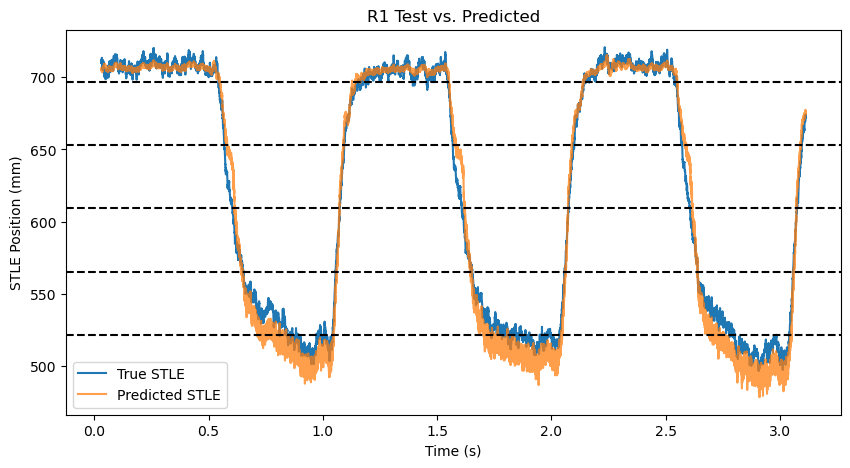

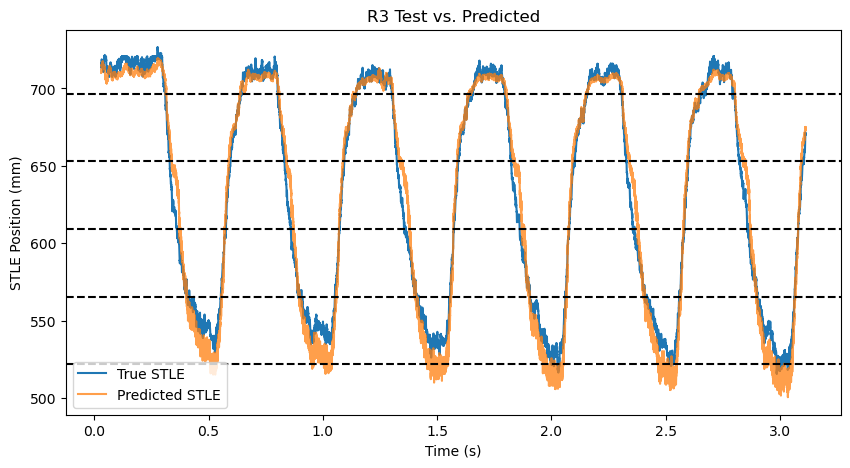

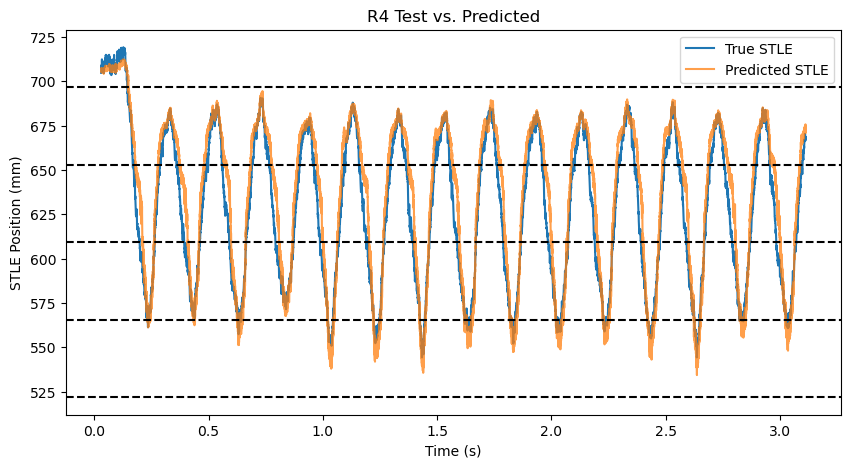

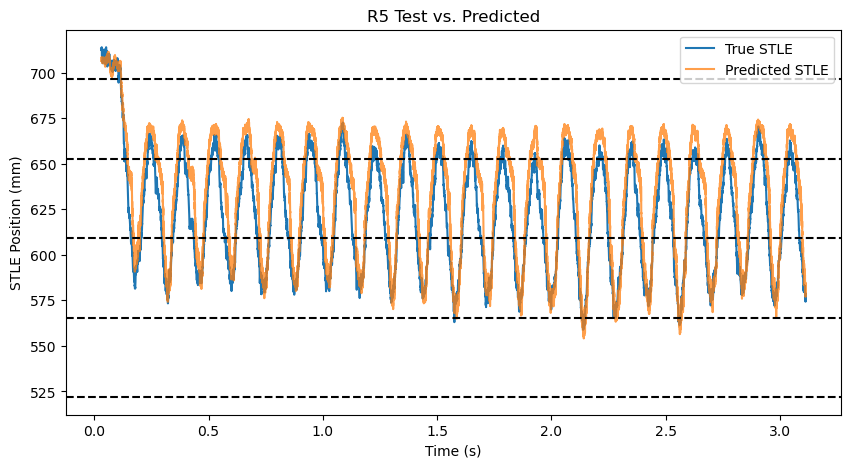

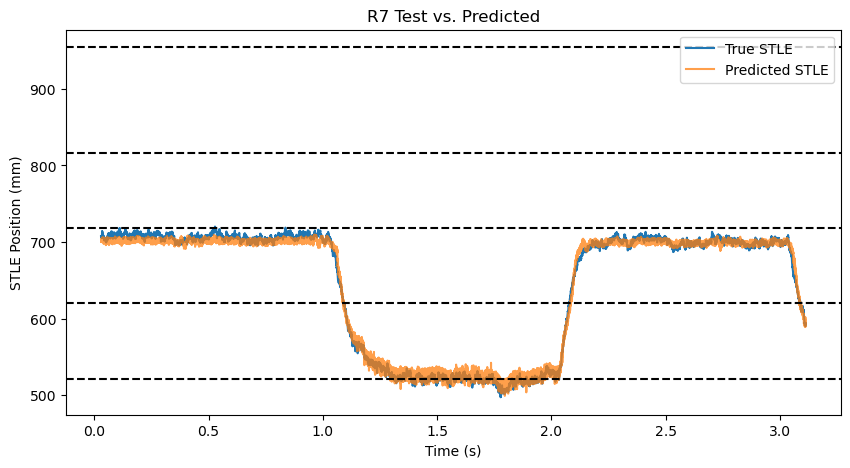

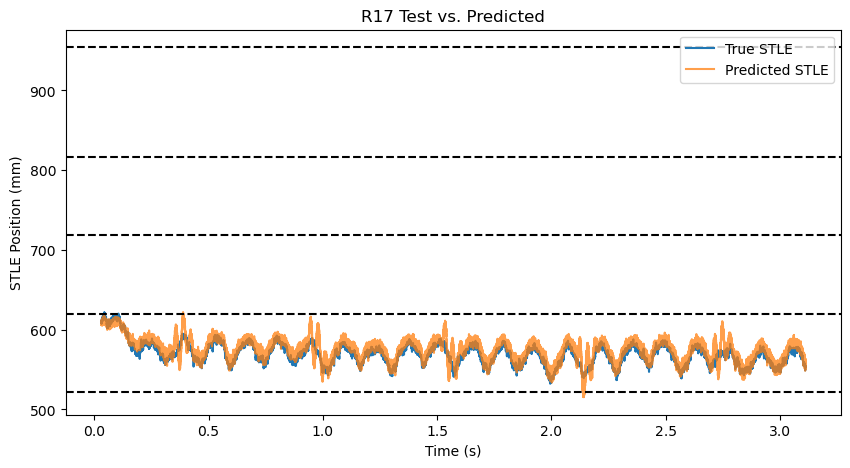

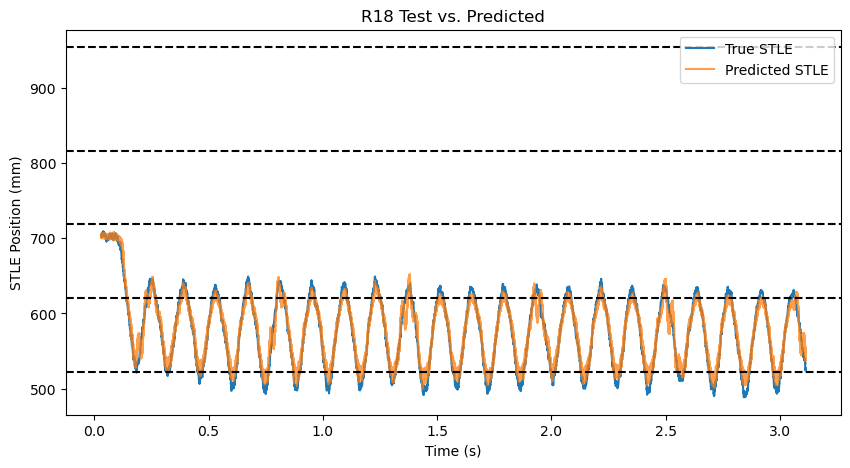

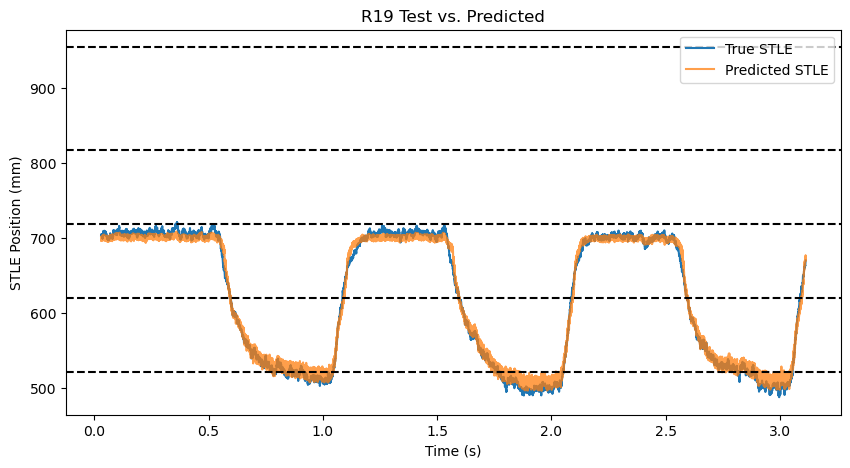

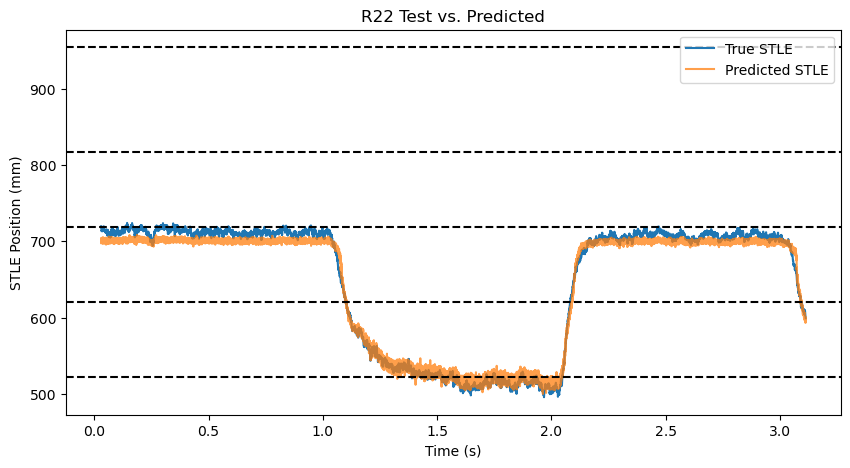

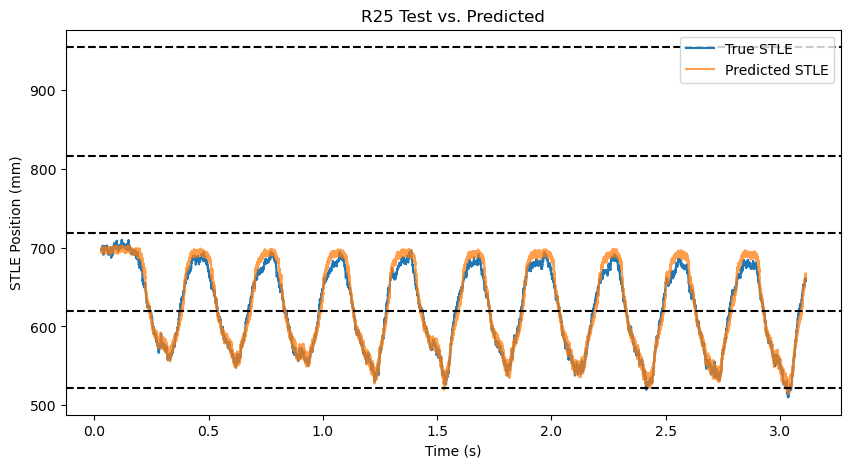

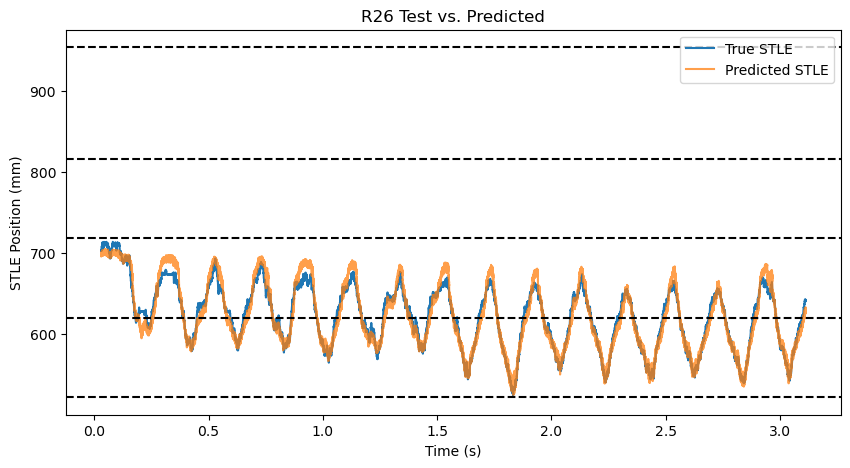

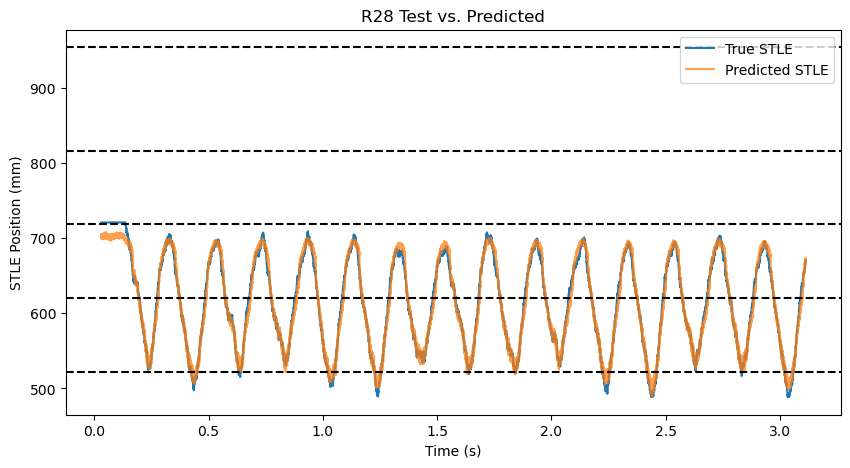

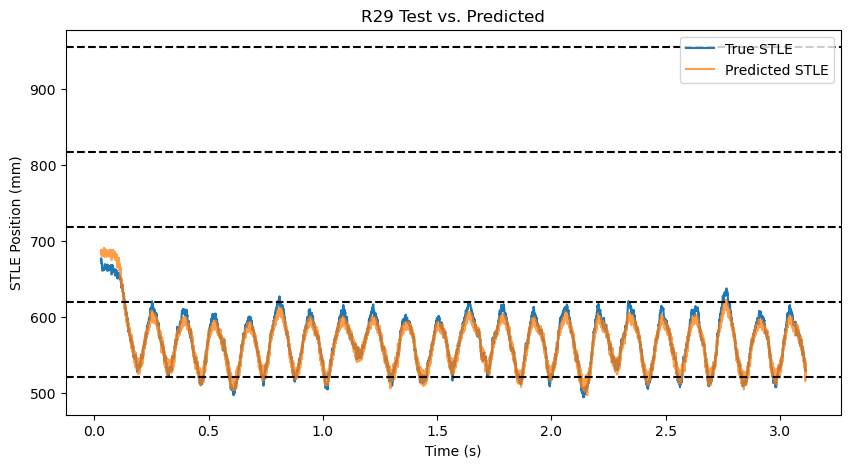

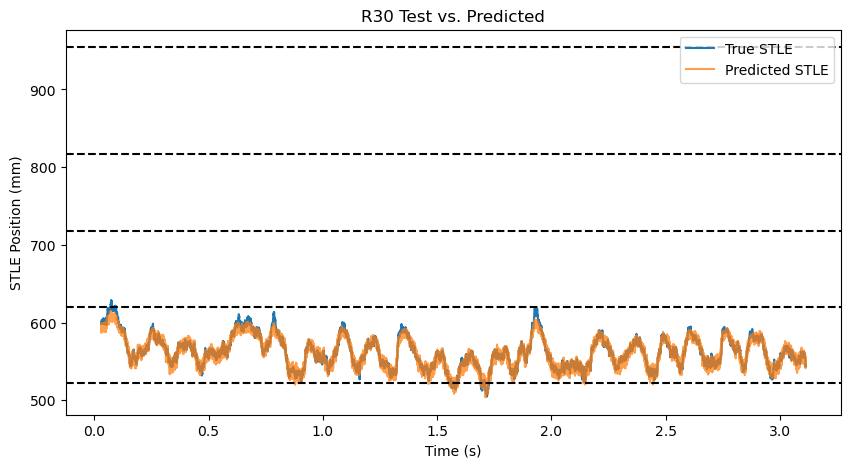

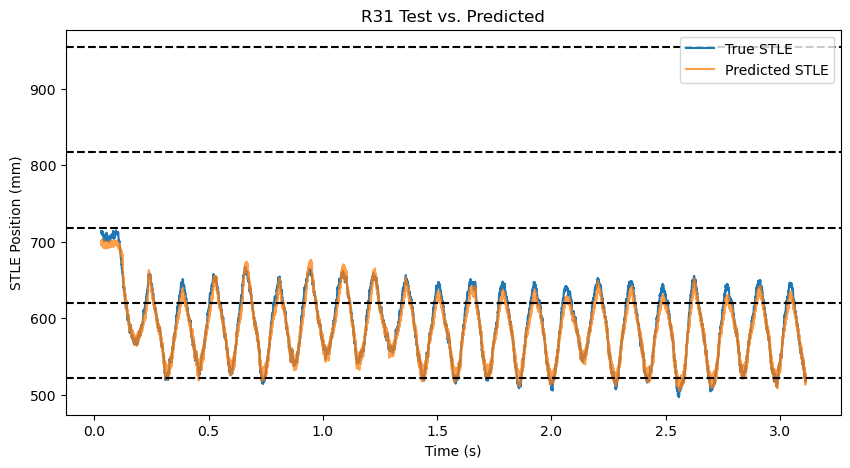

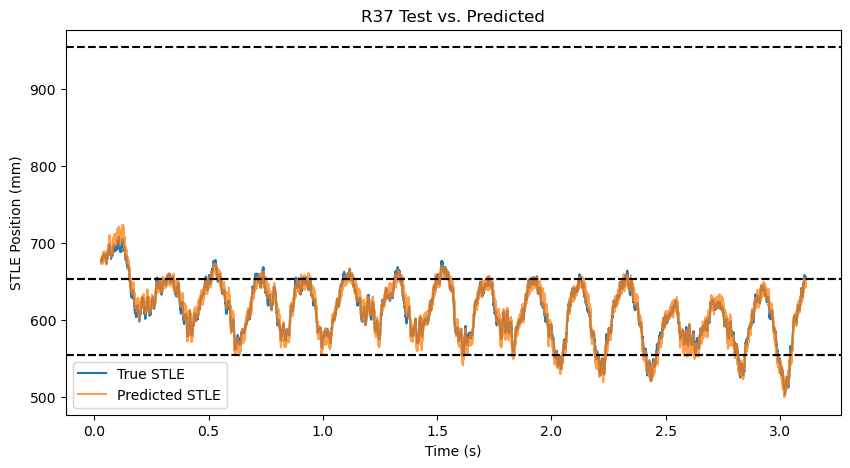

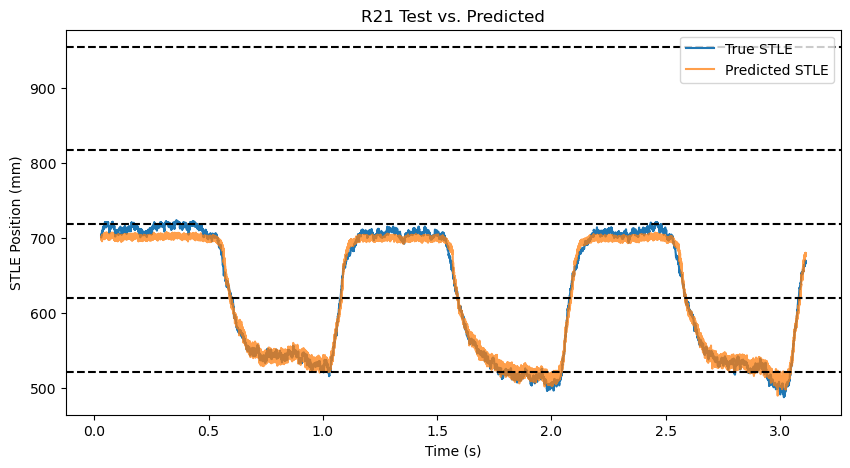

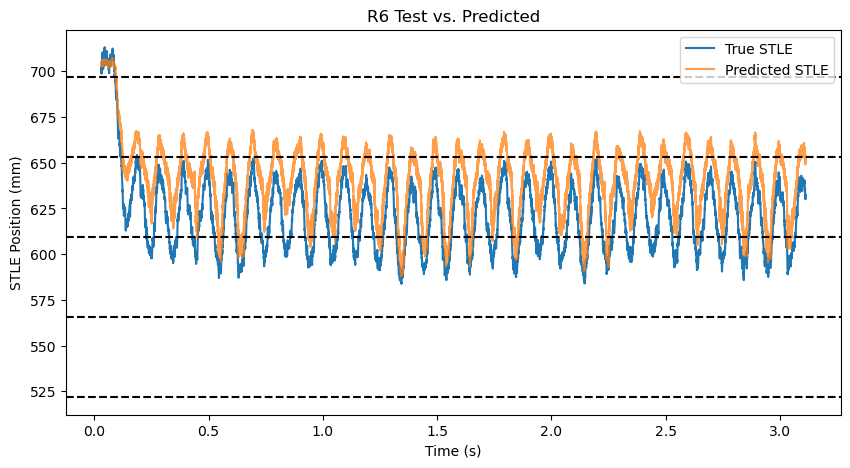

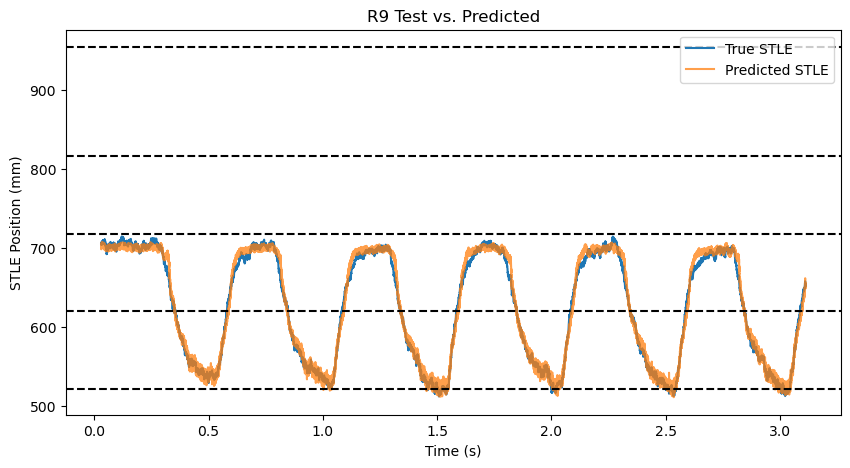

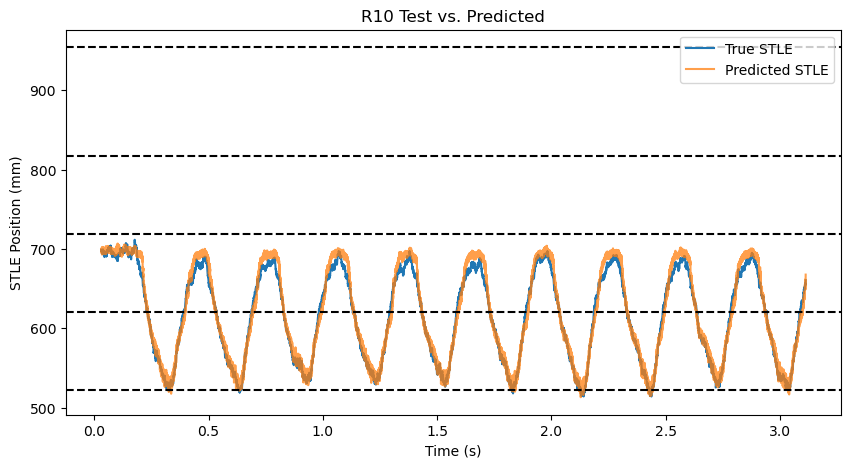

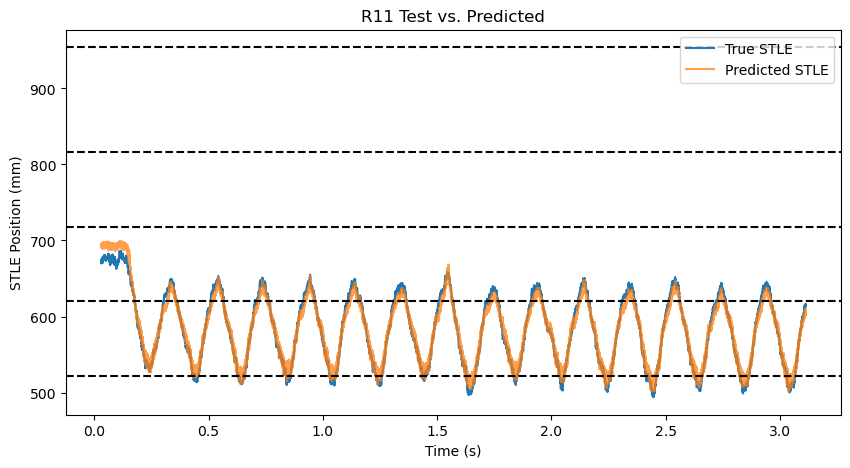

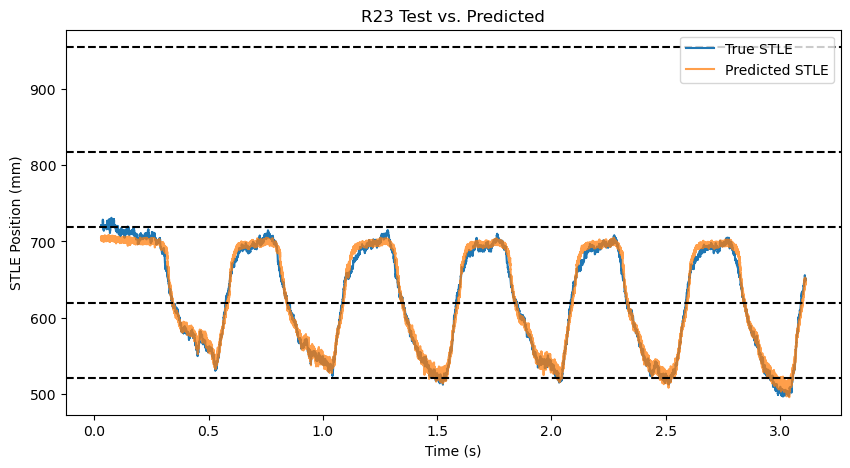

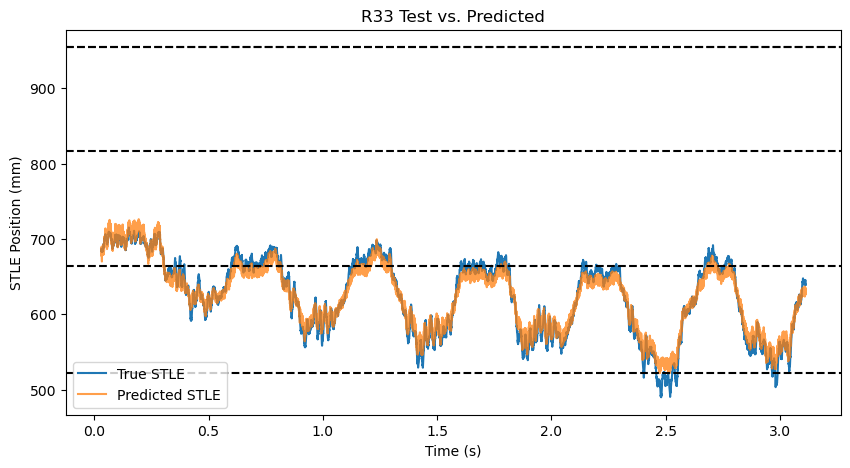

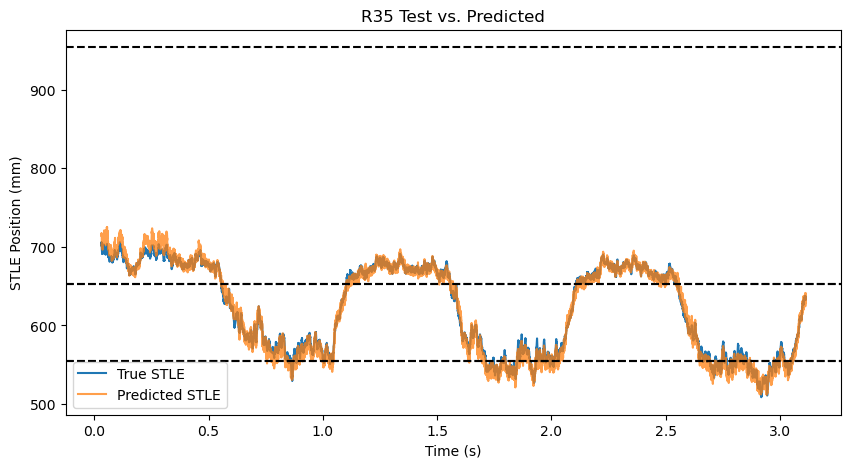

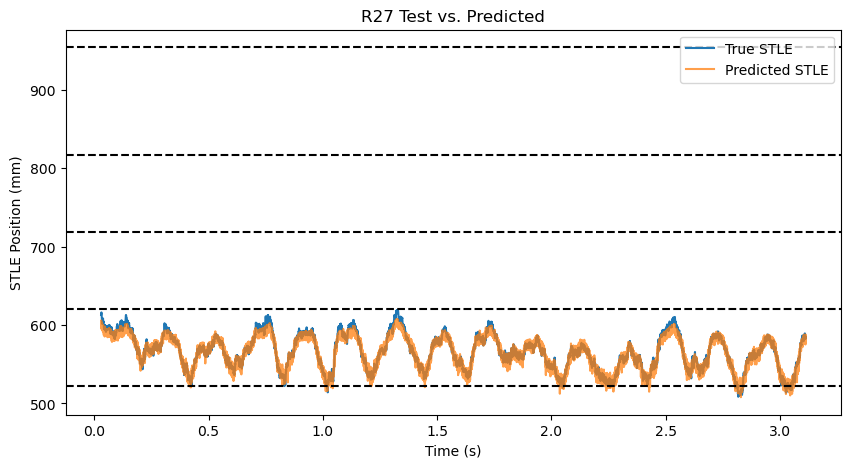

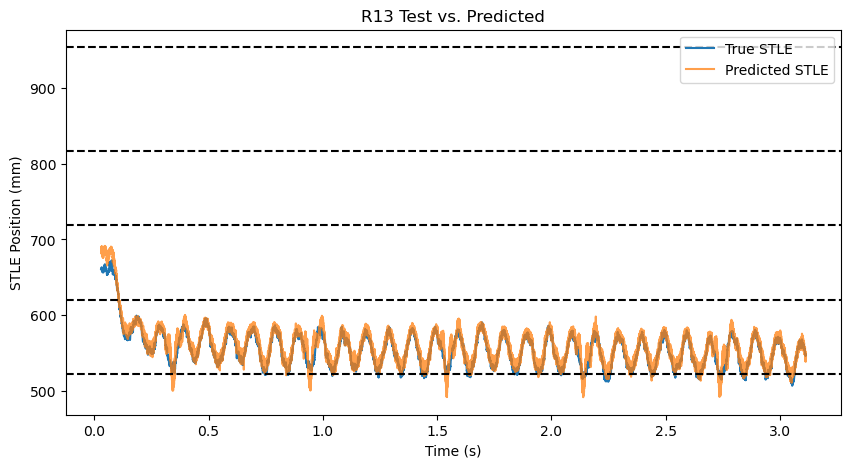

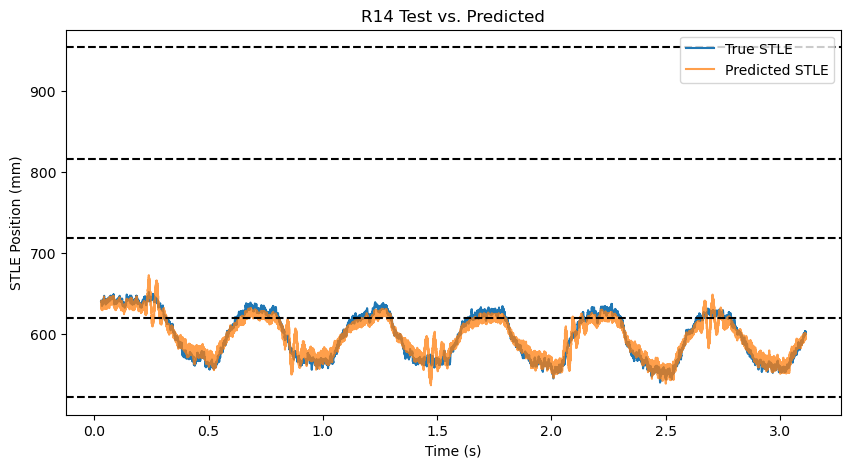

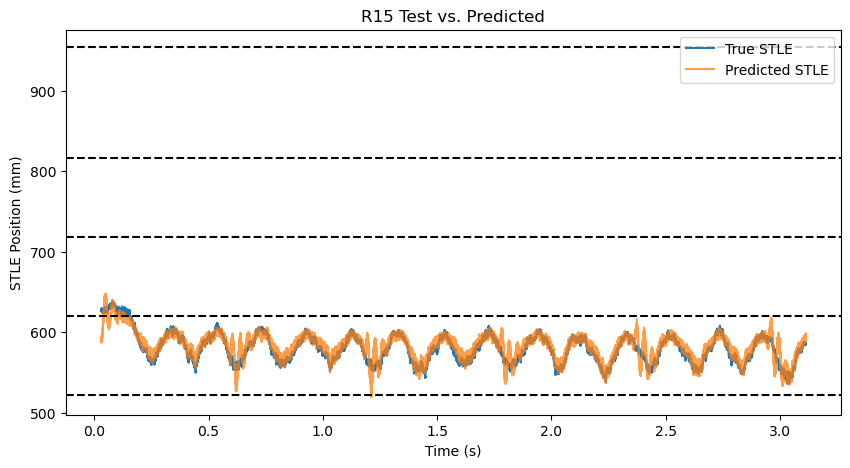

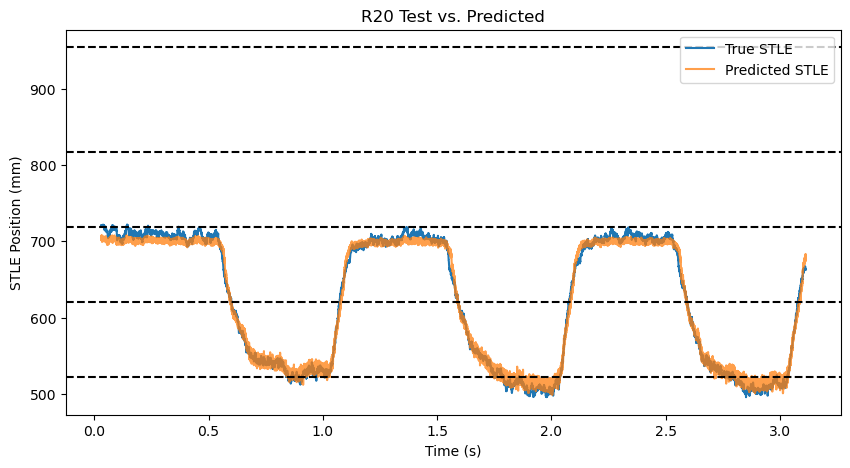

In [19]:
for i in test_run:
    result = full_rolled_test[full_rolled_test['Run'] == i]
    plt.figure(figsize=(10,5))
    plt.plot(result['time'].sort_values(), result['x1'],label='True STLE')
    plt.plot(result['time'].sort_values(), result['pred'],label='Predicted STLE',alpha=0.75)
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.legend()
    for j in location_list:
        plt.axhline(y=result[j].iloc[0], color='black', linestyle='--')
        
    plt.title(f"{i}" + ' Test vs. Predicted')
    plt.show()

# Neural Network

In [35]:
def RunNeuralNet(train_df, test_df):
    X_train = train_df.drop(['x1','time','Run','px1','px2','px3','px4','px5','H','W'],axis=1)
    X_test = test_df.drop(['x1','time','Run','px1','px2','px3','px4','px5','H','W','pred'],axis=1)
    y_train = train_df['x1']
    y_test = test_df['x1']

    ss = StandardScaler()

    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    model = Sequential()

    model.add(Dense(20, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
    
    model.fit(x=X_train_scaled,y=y_train.values,
          validation_data=(X_test_scaled,y_test.values),
          batch_size=128,epochs=100,callbacks=[early_stopping])
    
    y_pred = model.predict(X_test_scaled)
    test_df = test_df.copy()
    test_df['pred'] = y_pred
    
    return test_df,model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [37]:
test_df,model = RunNeuralNet(full_rolled_train, full_rolled_test)

Epoch 1/100
1686/1686 [==============================] - 3s 1ms/step - loss: 77438.4375 - val_loss: 3575.2463
Epoch 2/100
1686/1686 [==============================] - 2s 1ms/step - loss: 2506.7024 - val_loss: 897.7236
Epoch 3/100
1686/1686 [==============================] - 2s 1ms/step - loss: 371.0828 - val_loss: 311.2192
Epoch 4/100
1686/1686 [==============================] - 2s 1ms/step - loss: 115.7882 - val_loss: 175.0578
Epoch 5/100
1686/1686 [==============================] - 2s 1ms/step - loss: 72.4568 - val_loss: 135.0270
Epoch 6/100
1686/1686 [==============================] - 2s 1ms/step - loss: 60.2816 - val_loss: 111.3188
Epoch 7/100
1686/1686 [==============================] - 2s 1ms/step - loss: 53.3098 - val_loss: 98.8860
Epoch 8/100
1686/1686 [==============================] - 2s 1ms/step - loss: 48.4726 - val_loss: 92.9160
Epoch 9/100
1686/1686 [==============================] - 2s 1ms/step - loss: 44.8526 - val_loss: 82.7948
Epoch 10/100
1686/1686 [=================

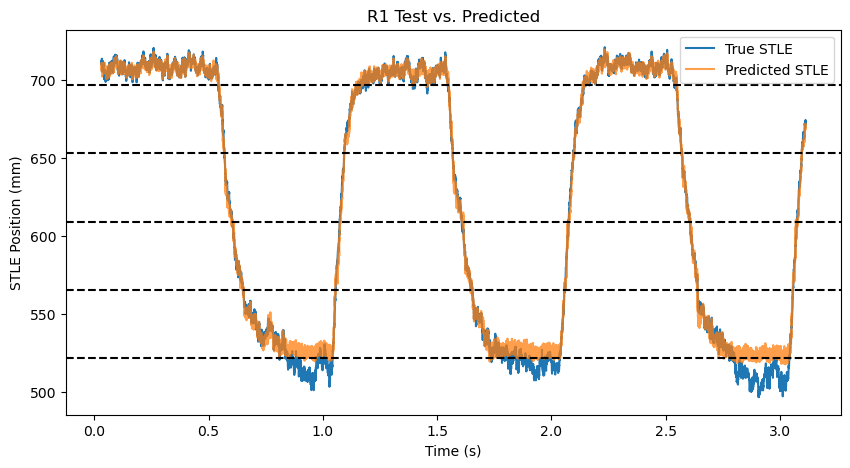

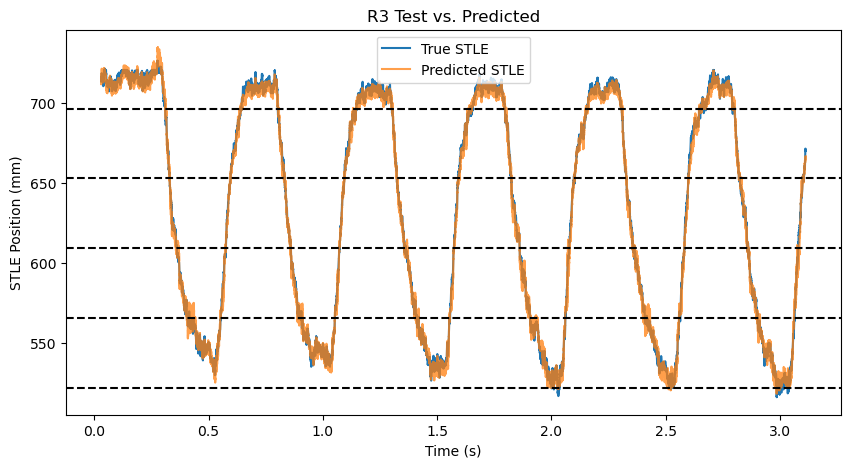

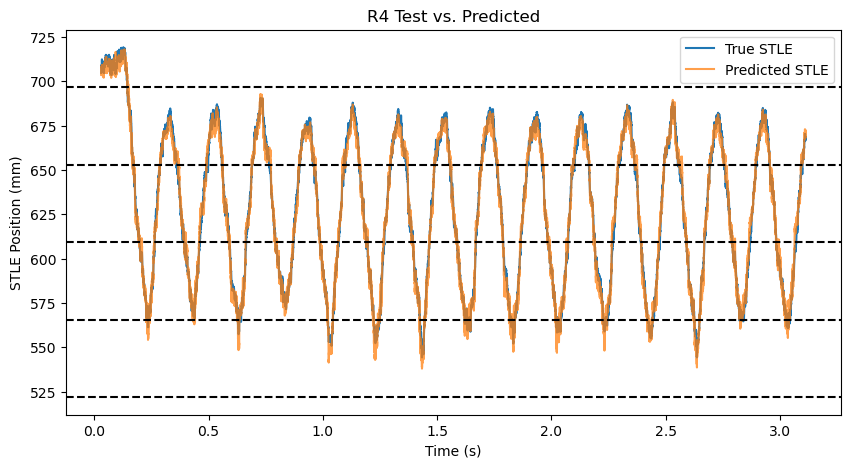

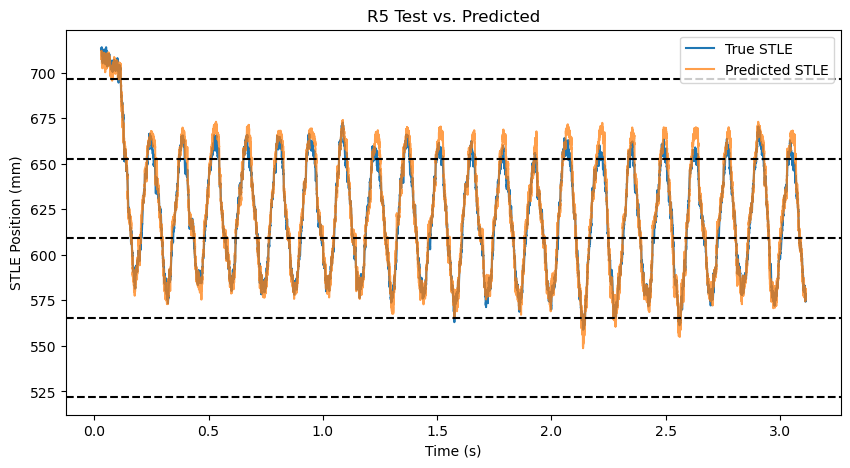

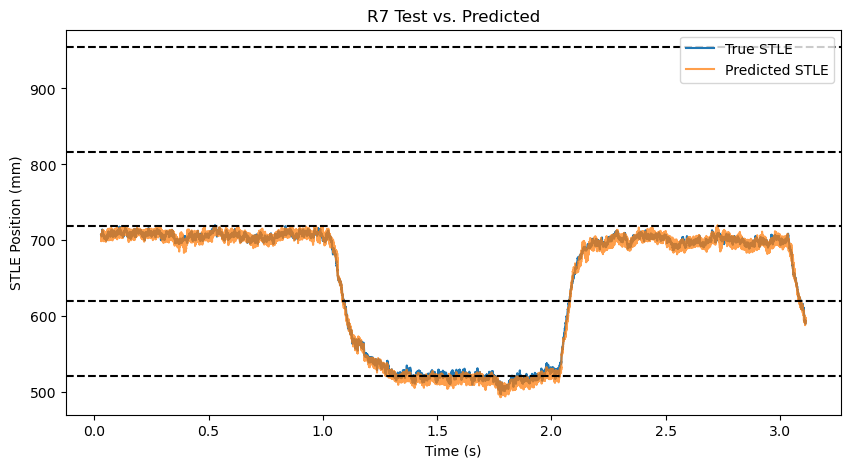

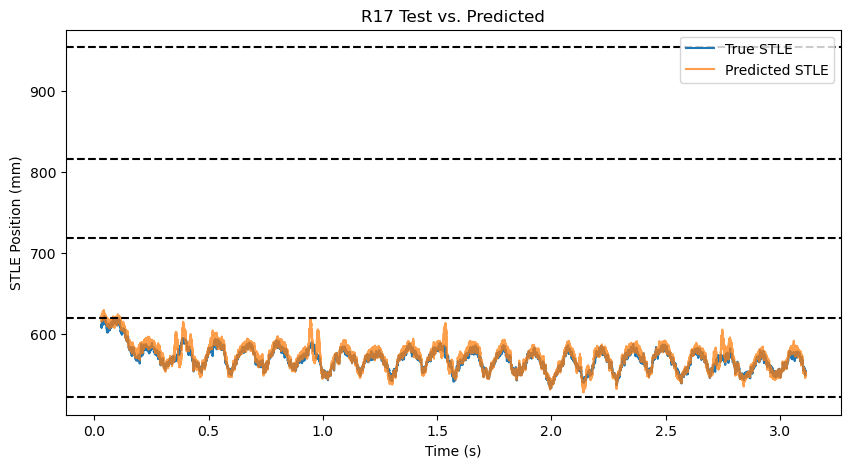

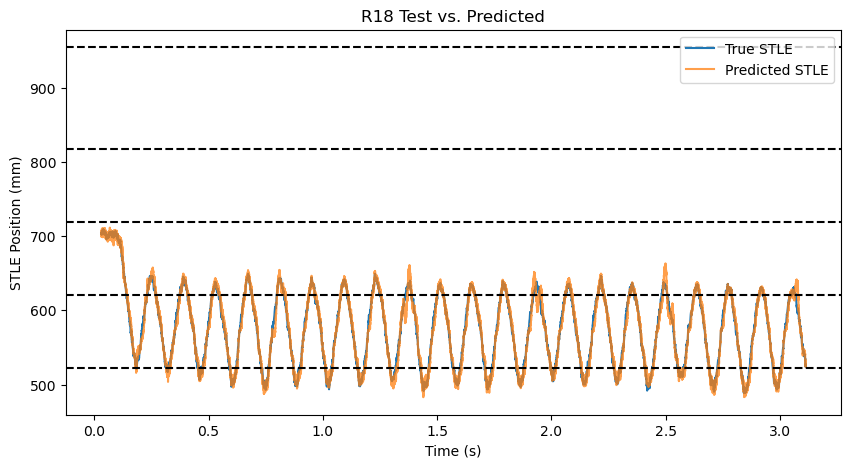

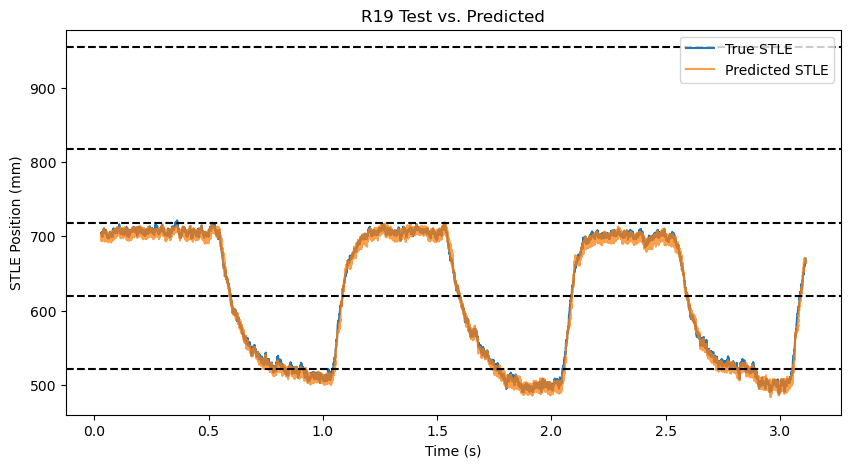

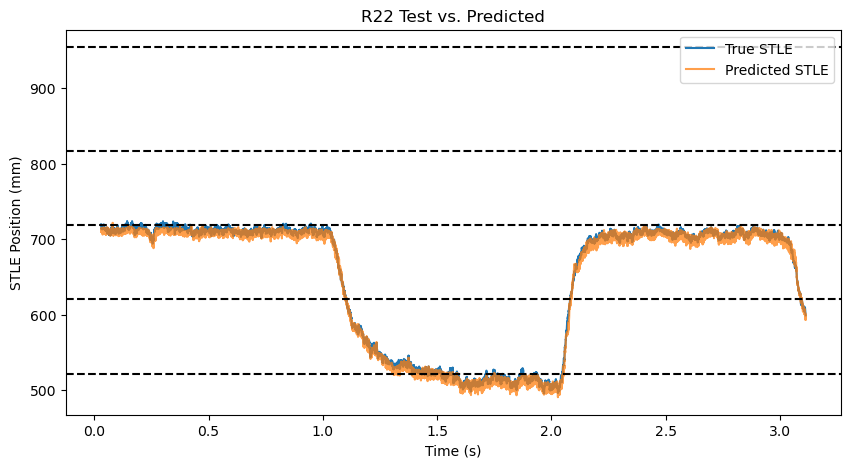

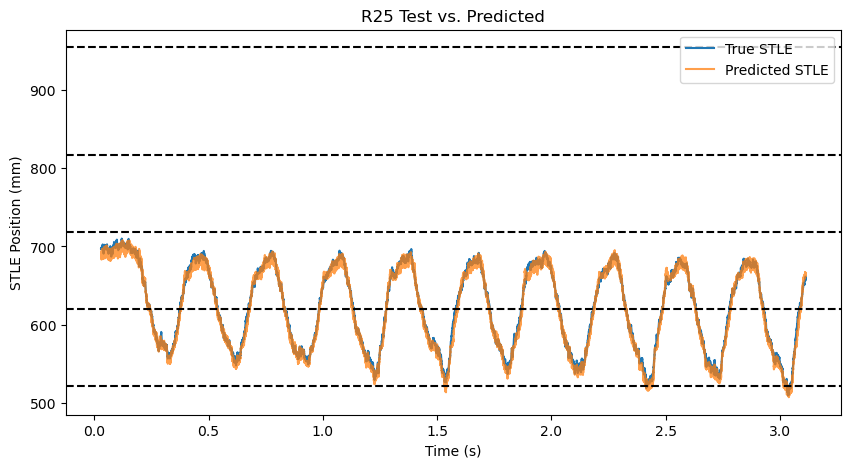

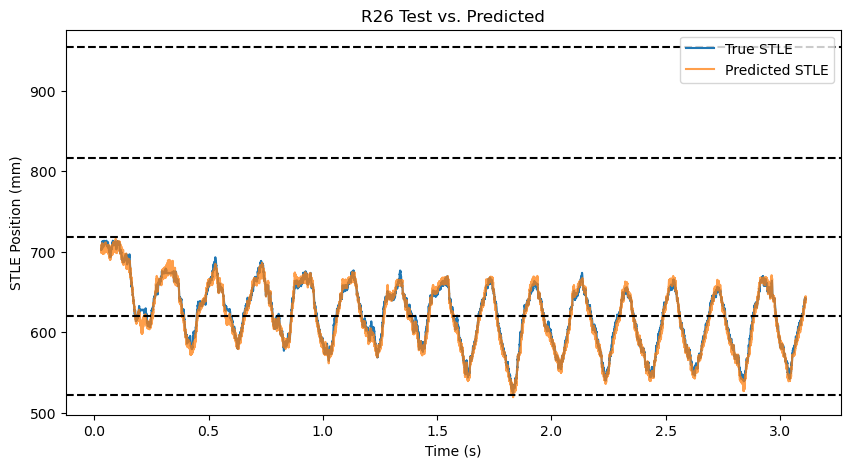

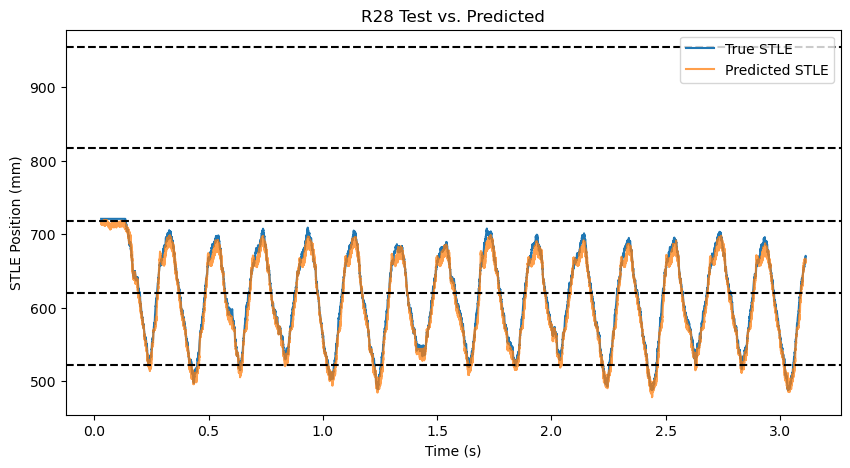

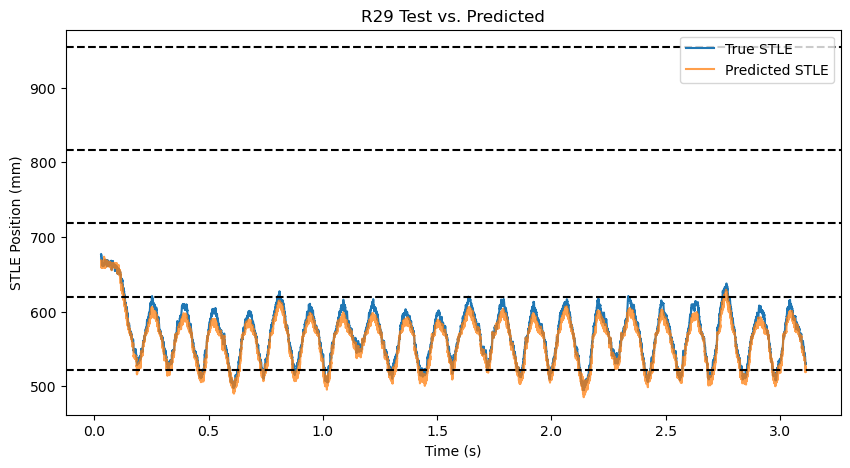

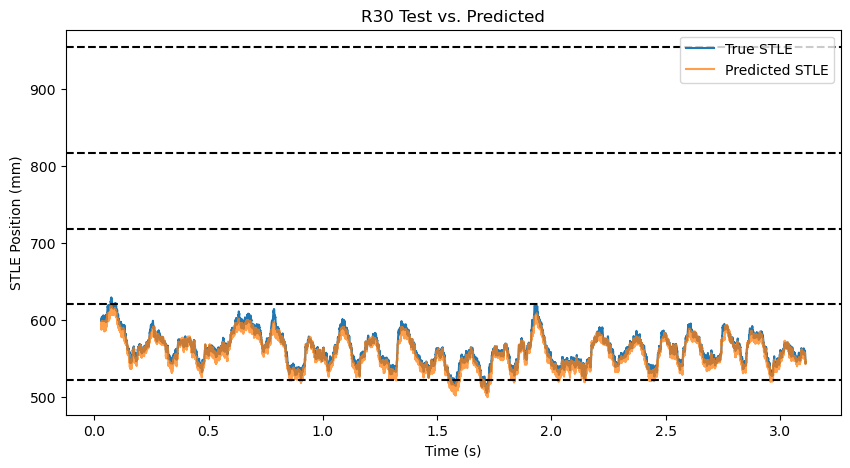

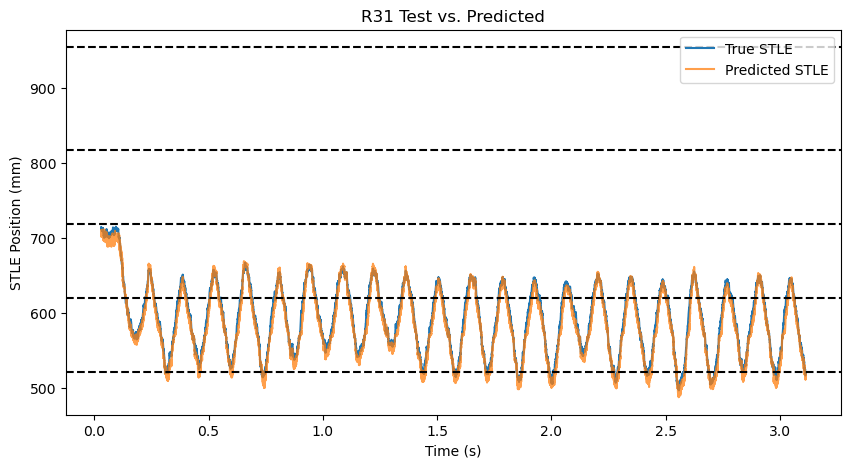

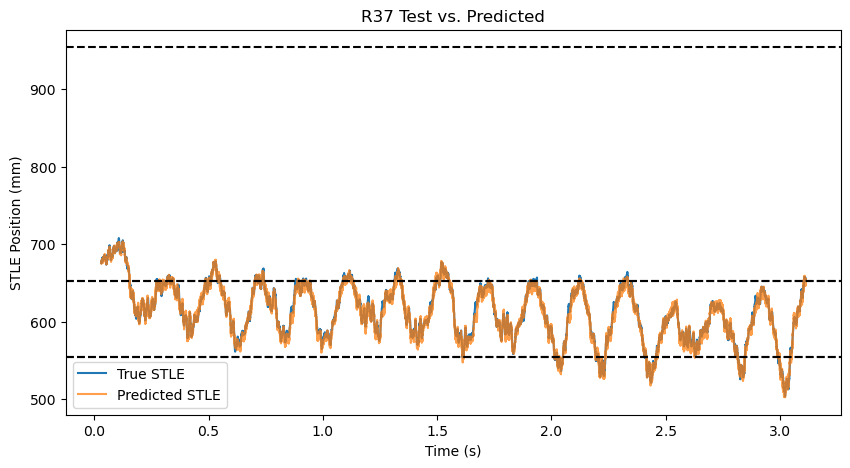

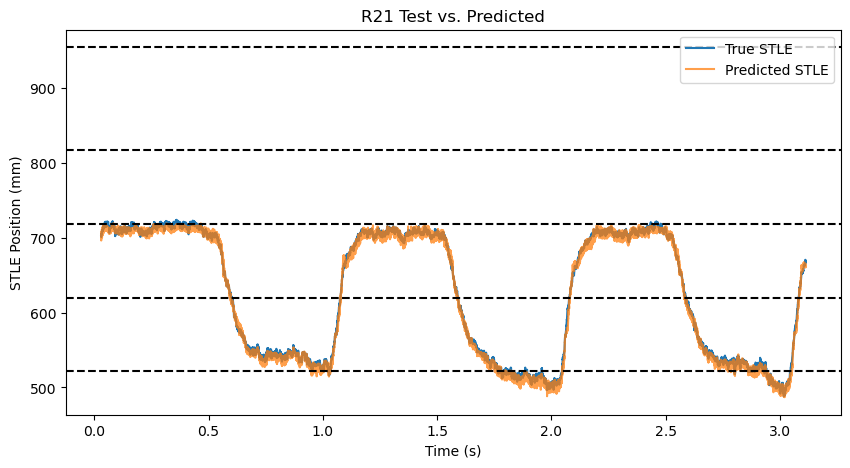

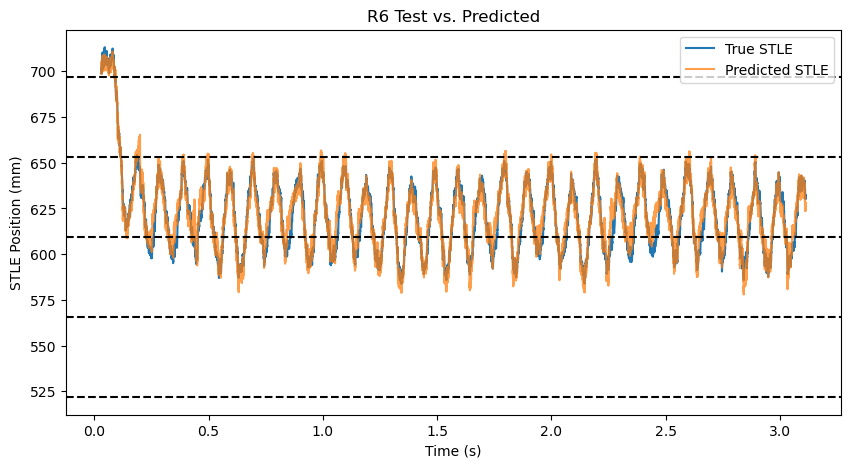

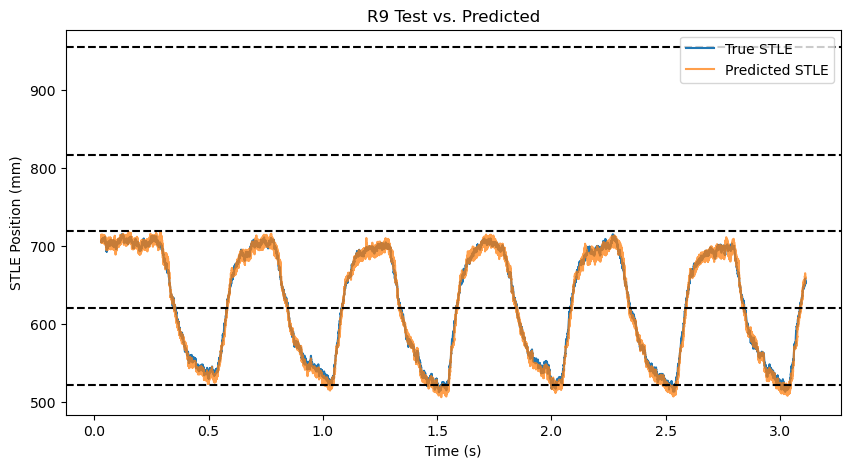

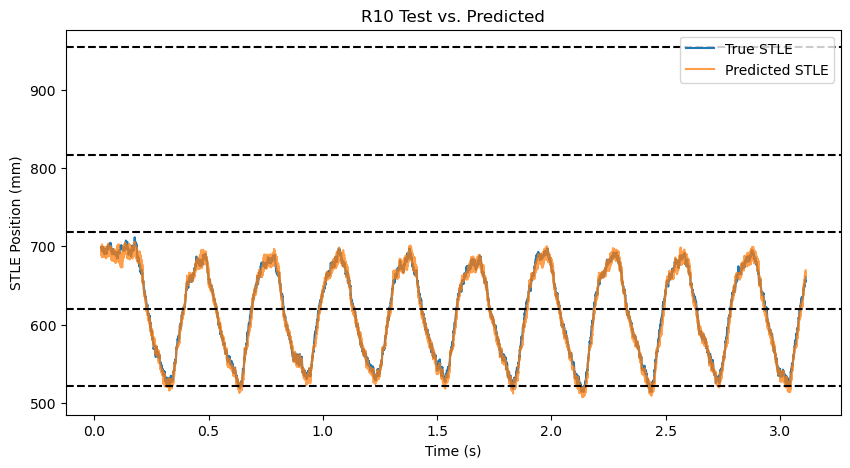

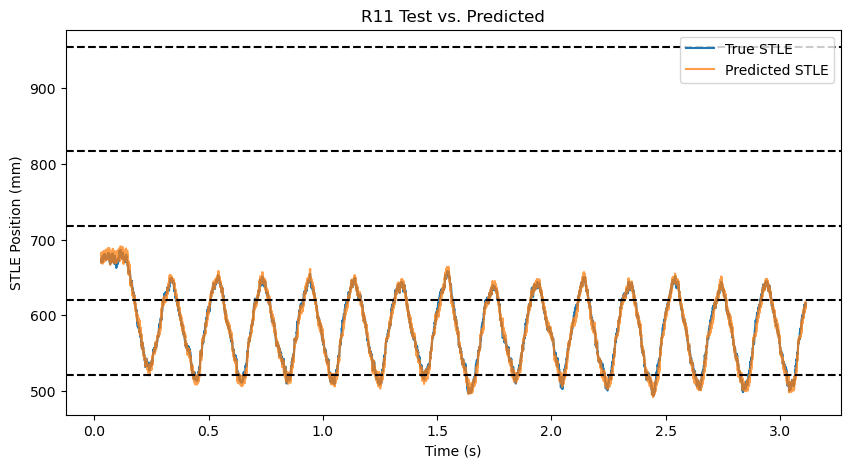

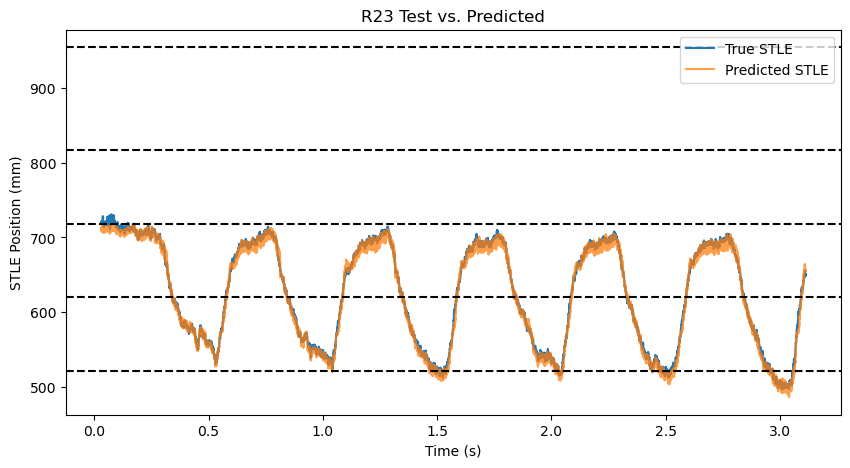

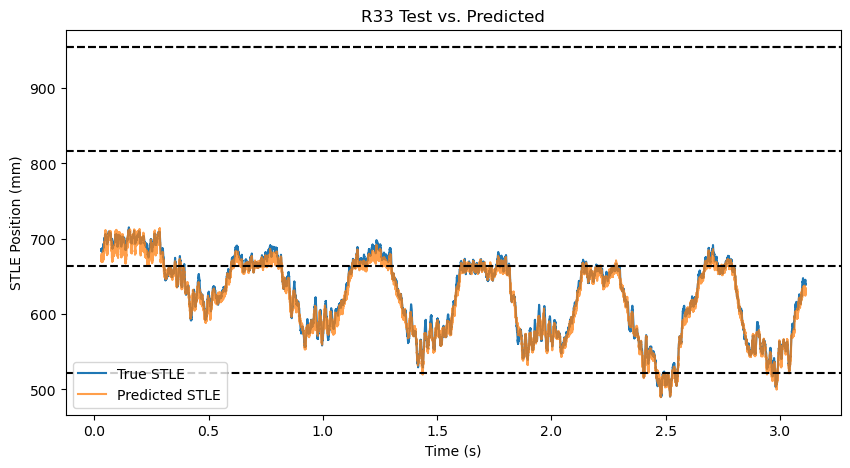

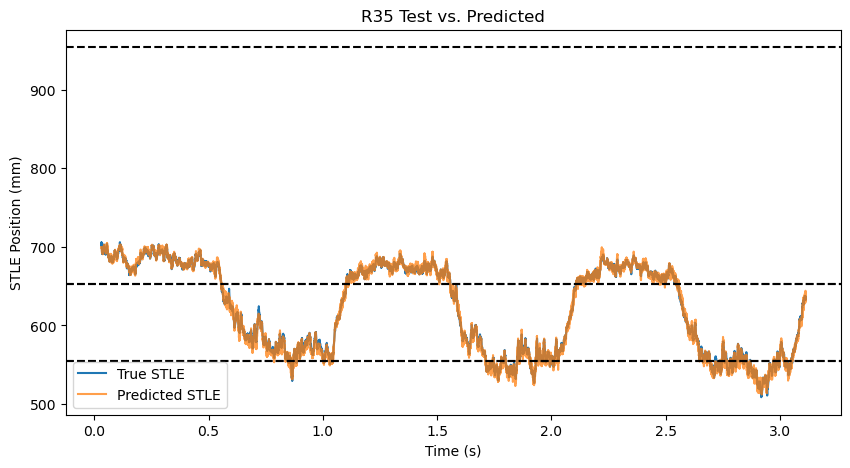

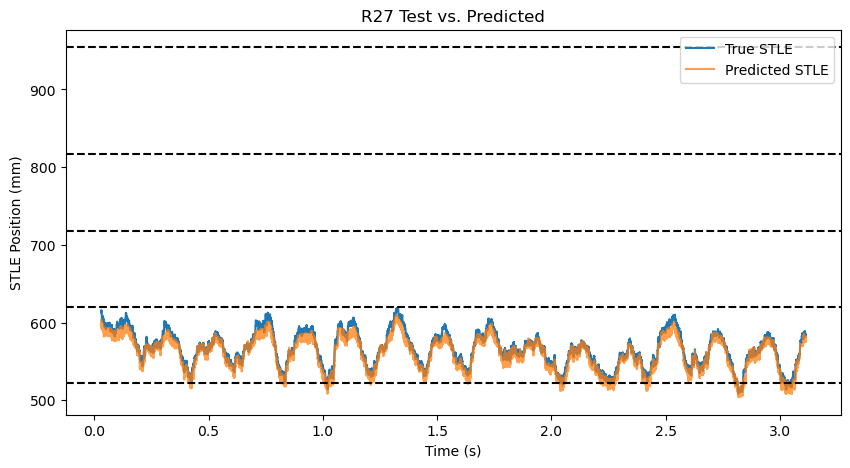

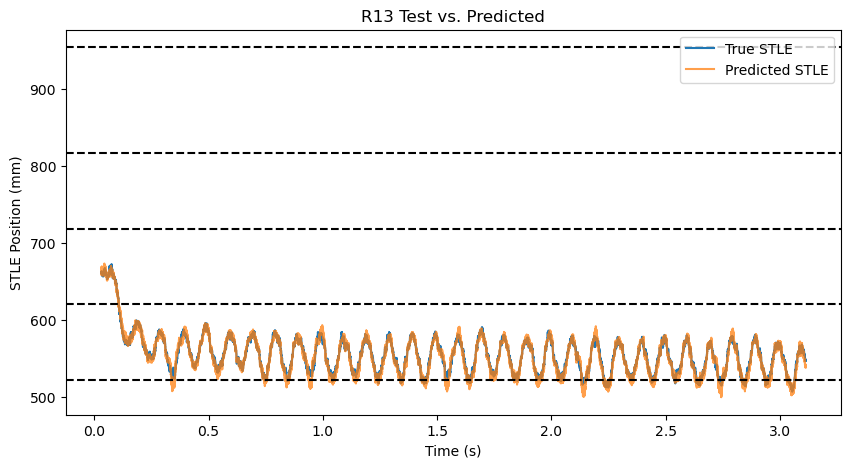

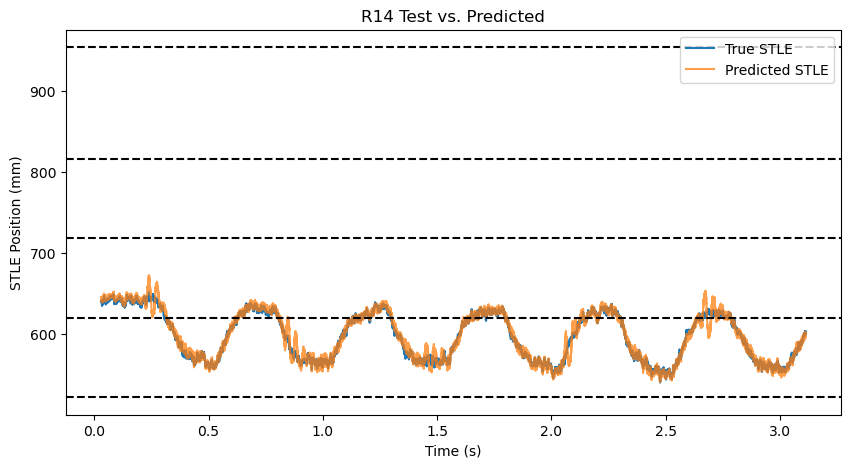

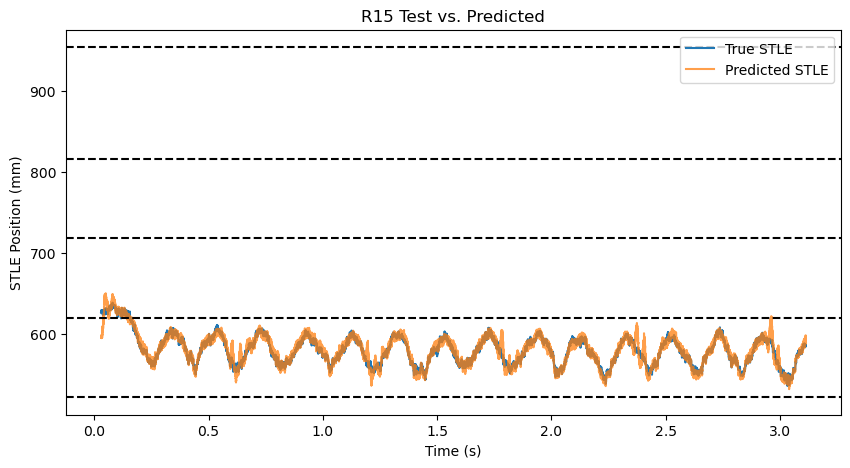

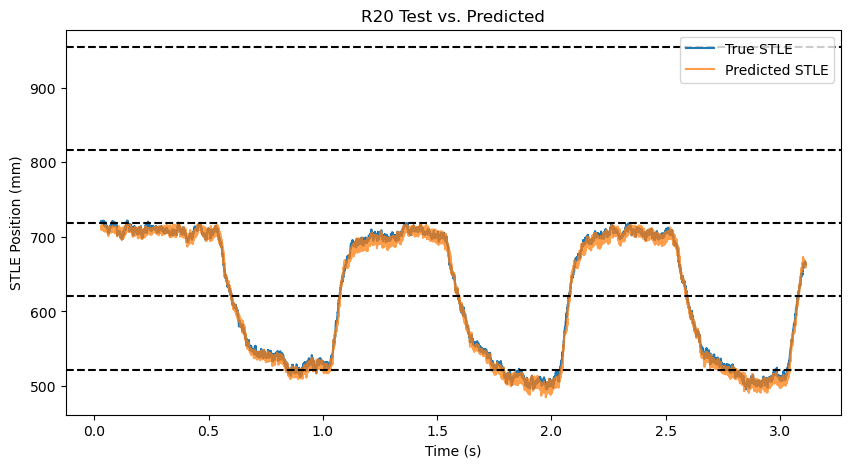

In [38]:
for i in test_run:
    result = test_df[test_df['Run'] == i]
    plt.figure(figsize=(10,5))
    plt.plot(result['time'].sort_values(), result['x1'],label='True STLE')
    plt.plot(result['time'].sort_values(), result['pred'],label='Predicted STLE',alpha=0.75)
    plt.xlabel('Time (s)')
    plt.ylabel('STLE Position (mm)')
    plt.legend()
    for j in location_list:
        plt.axhline(y=result[result['Run']==i][j].unique(), color='black', linestyle='--')
        
    plt.title(f"{i}" + ' Test vs. Predicted')
    plt.savefig('../code/figures/UMICH/Neural Network/'+str(i))

    plt.show()

In [39]:
model.save('../data/umich_model')

INFO:tensorflow:Assets written to: ../data/umich_model/assets


INFO:tensorflow:Assets written to: ../data/umich_model/assets


# Transfer Learning (kind of) Method

- Use the pre-trained Michigan model to predict series of simulated dataset

In [69]:
from tensorflow.keras.models import load_model

In [70]:
full_train = pd.read_csv("../data/sim_train_no_roll.csv",index_col=0)
full_test = pd.read_csv("../data/sim_test_no_roll.csv",index_col=0)

train_roll = rolling_avg(full_train).iloc[300:]
test_roll = rolling_avg(full_test).iloc[300:]

In [71]:
X_train = train_roll.drop(['x','time','run','px1','px2','px3','px4','px5'],axis=1)
X_test = test_roll.drop(['x','time','run','px1','px2','px3','px4','px5'],axis=1)
y_train = train_roll['x']
y_test = test_roll['x']

ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [72]:
new_model = Sequential()

new_model.trainable = True

new_model.add(base_model)
new_model.add(Dense(50, activation='relu'))

new_model.add(Dense(1))
              
new_model.compile(optimizer='adam',loss='mse')

In [73]:
base_model = load_model('../data/umich_model/')

In [75]:
new_model.fit(x=X_train_scaled,y=y_train.values,
          validation_data=(X_test_scaled,y_test.values),
          batch_size=300,epochs=100)

Epoch 1/100
399/399 [==============================] - 0s 1ms/step - loss: 3.8730e-05 - val_loss: 0.0573
Epoch 2/100
399/399 [==============================] - 0s 969us/step - loss: 3.9828e-05 - val_loss: 0.0565
Epoch 3/100
399/399 [==============================] - 0s 966us/step - loss: 3.7446e-05 - val_loss: 0.0559
Epoch 4/100
399/399 [==============================] - 0s 963us/step - loss: 3.9884e-05 - val_loss: 0.0626
Epoch 5/100
399/399 [==============================] - 0s 965us/step - loss: 5.2775e-05 - val_loss: 0.0562
Epoch 6/100
399/399 [==============================] - 0s 960us/step - loss: 3.1795e-05 - val_loss: 0.0610
Epoch 7/100
399/399 [==============================] - 0s 959us/step - loss: 5.4455e-05 - val_loss: 0.0597
Epoch 8/100
399/399 [==============================] - 0s 965us/step - loss: 3.2288e-05 - val_loss: 0.0643
Epoch 9/100
399/399 [==============================] - 0s 960us/step - loss: 2.9180e-05 - val_loss: 0.0599
Epoch 10/100
399/399 [=================

Epoch 77/100
399/399 [==============================] - 0s 955us/step - loss: 3.1313e-05 - val_loss: 0.0590
Epoch 78/100
399/399 [==============================] - 0s 963us/step - loss: 1.7510e-05 - val_loss: 0.0568
Epoch 79/100
399/399 [==============================] - 0s 959us/step - loss: 1.5048e-05 - val_loss: 0.0570
Epoch 80/100
399/399 [==============================] - 0s 955us/step - loss: 1.7828e-05 - val_loss: 0.0569
Epoch 81/100
399/399 [==============================] - 0s 968us/step - loss: 2.8793e-05 - val_loss: 0.0593
Epoch 82/100
399/399 [==============================] - 0s 959us/step - loss: 1.6647e-05 - val_loss: 0.0606
Epoch 83/100
399/399 [==============================] - 0s 957us/step - loss: 1.9702e-05 - val_loss: 0.0604
Epoch 84/100
399/399 [==============================] - 0s 959us/step - loss: 1.6270e-05 - val_loss: 0.0607
Epoch 85/100
399/399 [==============================] - 0s 955us/step - loss: 2.0010e-05 - val_loss: 0.0638
Epoch 86/100
399/399 [======

In [79]:
y_pred = new_model.predict(X_test_scaled)
full_sim_test_comparison = test_roll.copy()
full_sim_test_comparison['pred'] = y_pred

6554/6554 [==============================] - 2s 252us/step


In [80]:
sim_test_runs = list(full_test['run'].unique())

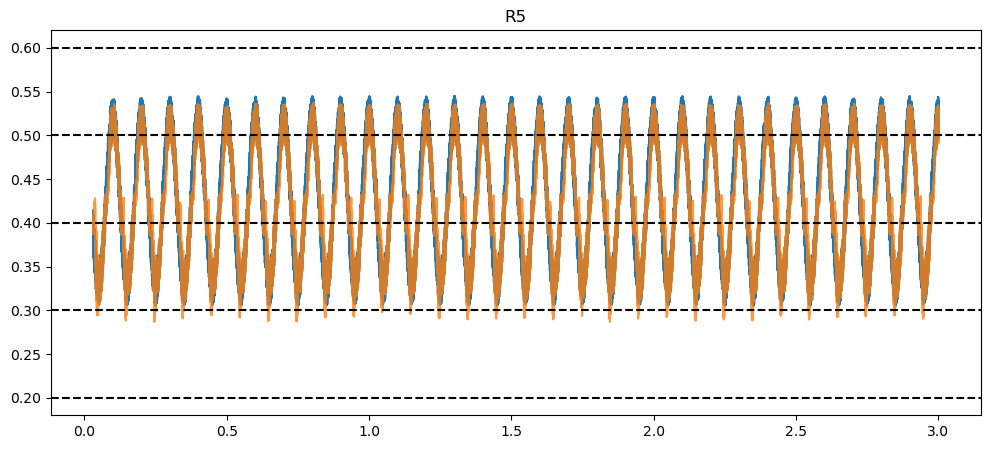

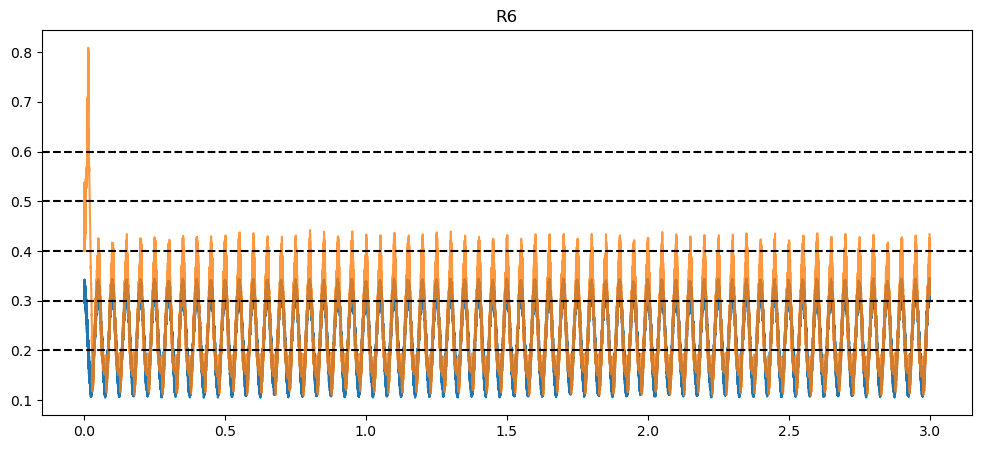

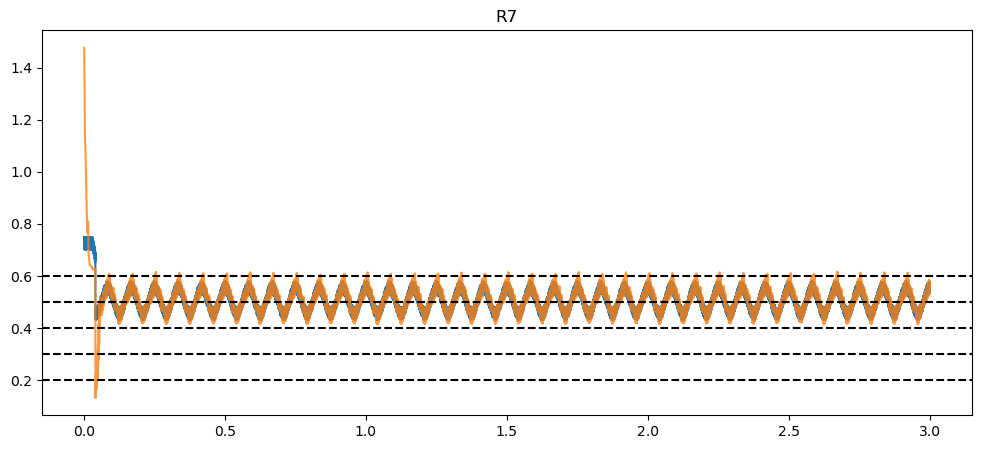

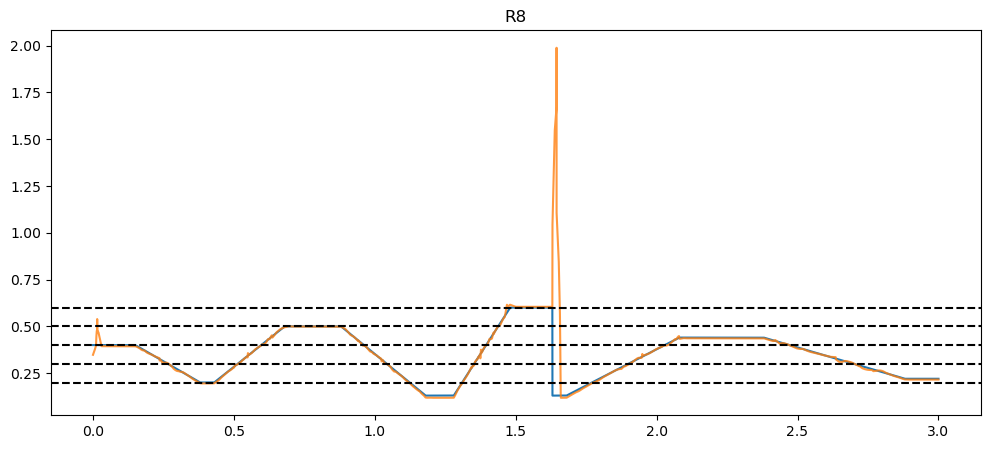

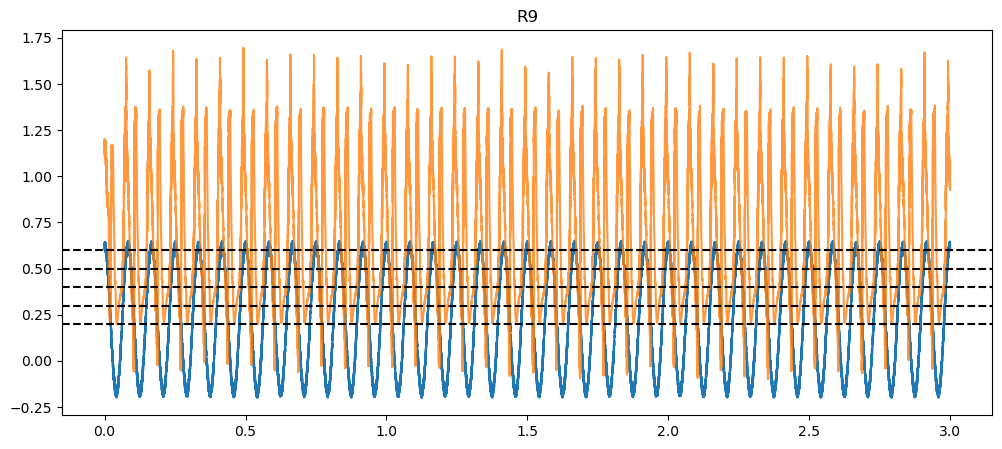

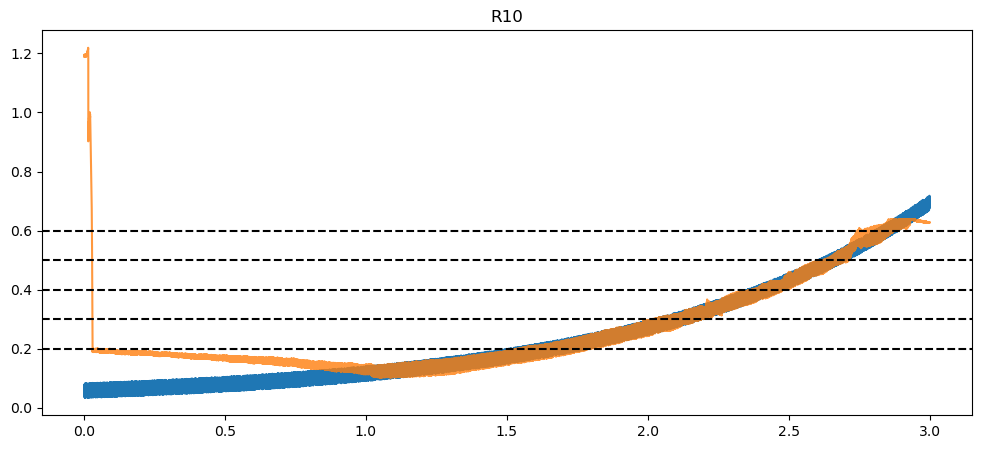

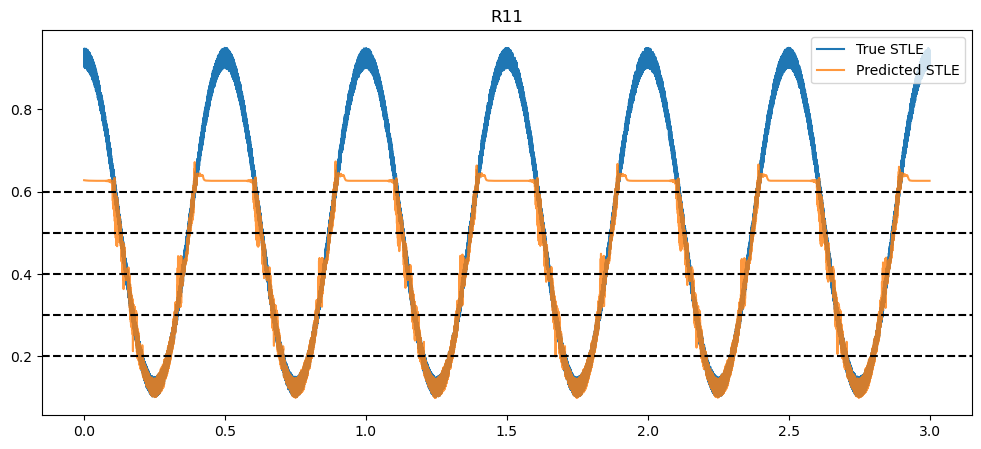

In [81]:
for j in sim_test_runs:
    plt.figure(figsize=(12,5))
    plt.plot(full_sim_test_comparison[full_sim_test_comparison['run']==j]['time'], 
            full_sim_test_comparison[full_sim_test_comparison['run']==j]['x'], label='True STLE')
    plt.plot(full_sim_test_comparison[full_sim_test_comparison['run']==j]['time'], 
            full_sim_test_comparison[full_sim_test_comparison['run']==j]['pred'], label='Predicted STLE', alpha=0.8)
    
    for k in range(5):
        plt.axhline(y=full_sim_test_comparison['px'+str(k+1)].iloc[0], color='black', linestyle='--')
    
    plt.title(j)

plt.legend()
plt.show()

Simulated results also work well, except for the parts that had to be extrapolated.